In [1]:
'''
Reconstructs straight tracks in 3D (with noise and inefficiency)
Using google TPUs to speed up the training
'''

from __future__ import print_function


!pip install keras_sequential_ascii
!pip install git+git://github.com/cpmpercussion/keras-mdn-layer.git#egg=keras-mdn-layer


#import ROOT
#from ROOT import TMVA, TFile, TTree, TCut, TChain, TString, TF1, TGraphErrors, TFile, TNtuple, TCanvas


import matplotlib.pyplot as plt
# Package imports
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
import scipy as sp
import logging

import tensorflow as tf

import os
import pprint

import keras

import mdn

from keras import backend as K
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, RepeatVector, LSTM, TimeDistributed
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Reshape
from keras.models import Sequential
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from matplotlib.pyplot import imshow

import sys
import time

np.random.seed(2348)

batch_size = 5000
batch_size_NN = 2*128 #2*128
epochs = 512 #512
pre_epochs =  16 #32 epochs for pre-traing using rms optimizer
post_epochs = 16 #64 post-training using SGD
steps_per_epoch = 2*8 #4*8

# input image dimensions
img_rows, img_cols = 400, 12 #28, 28

Using TensorFlow backend.


In [0]:



####################################################################################################

# Data parameters
det_width = img_rows  # stupid, to be changed
det_depth = img_cols
det_shape = (det_depth, det_width)#, det_width)

canals=3 #number of detector channels
canal_depth=80 #empty channel depth
canal_det=int(det_depth/canals) #detector channel depth


# Number of tracks in each event follows Poisson distribution
mean_tracks = 2
max_tracks  = 2

#probability of noise and the efficiency<1
prob_noise = 0.01
efficiency = 0.90

#slope multiplicator - reduce the slope to slope_mult*max_slope
slope_mult = 1

#MDN parameters
mdn_out=2
mdn_mix=3

y_new = []

################################ matplotlib-hep ########################################### 


def calc_nbins(x, maximum=150):
    n =  (max(x) - min(x)) / (2 * len(x)**(-1/3) * (np.percentile(x, 75) - np.percentile(x, 25)))
    print(f"bins_proposed: {n}")
    return np.floor(min(n, maximum))

def poisson_limits(N, kind, confidence=0.6827):
    alpha = 1 - confidence
    upper = np.zeros(len(N))
    lower = np.zeros(len(N))
    if kind == 'gamma':
        lower = stats.gamma.ppf(alpha / 2, N)
        upper = stats.gamma.ppf(1 - alpha / 2, N + 1)
    elif kind == 'sqrt':
        err = np.sqrt(N)
        lower = N - err
        upper = N + err
    else:
        raise ValueError('Unknown errorbar kind: {}'.format(kind))
    # clip lower bars
    lower[N==0] = 0
    return N - lower, upper - N

def histpoints(x, bins=None, xerr=None, yerr='gamma', normed=False, **kwargs):
    """
    Plot a histogram as a series of data points.
    Compute and draw the histogram of *x* using individual (x,y) points
    for the bin contents.
    By default, vertical poisson error bars are calculated using the
    gamma distribution.
    Horizontal error bars are omitted by default.
    These can be enabled using the *xerr* argument.
    Use ``xerr='binwidth'`` to draw horizontal error bars that indicate
    the width of each histogram bin.
    Parameters
    ---------
    x : (n,) array or sequence of (n,) arrays
        Input values. This takes either a single array or a sequence of
        arrays, which are not required to be of the same length.
    """
    import matplotlib.pyplot as plt

    if bins is None:
        bins = int(calc_nbins(x))

    h, bins = np.histogram(x, bins=bins)
    width = bins[1] - bins[0]
    center = (bins[:-1] + bins[1:]) / 2
    area = sum(h * width)

    if isinstance(yerr, str):
        yerr = poisson_limits(h, yerr)

    if xerr == 'binwidth':
        xerr = width / 2

    if normed:
        h = h / area
        yerr = yerr / area
        area = 1.

    if not 'color' in kwargs:
        kwargs['color'] = 'black'

    if not 'fmt' in kwargs:
        kwargs['fmt'] = 'o'

    plt.errorbar(center, h, xerr=xerr, yerr=yerr, **kwargs)

    return center, (yerr[0], h, yerr[1]), area

def make_split(ratio, gap=0.12):
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from matplotlib.ticker import MaxNLocator
    cax = plt.gca()
    box = cax.get_position()
    xmin, ymin = box.xmin, box.ymin
    xmax, ymax = box.xmax, box.ymax
    gs = GridSpec(2, 1, height_ratios=[ratio, 1 - ratio], left=xmin, right=xmax, bottom=ymin, top=ymax)
    gs.update(hspace=gap)

    ax = plt.subplot(gs[0])
    plt.setp(ax.get_xticklabels(), visible=False)
    bx = plt.subplot(gs[1], sharex=ax)

    return ax, bx

def plot_pull(data, func,title):

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator

    ax, bx = make_split(0.8)

    plt.sca(ax)

    x, y, norm = histpoints(data)

    lower, upper = ax.get_xlim()

    xs = np.linspace(-max(abs(lower), upper), max(abs(lower), upper), 200)
    plt.plot(xs, norm * func(xs), 'b-')

    #plt.gca().yaxis.set_major_locator(MaxNLocator(prune='lower'))
    plt.title(title)
    plt.sca(bx)

    resid = y[1] - norm * func(x)
    err = np.zeros_like(resid)
    err[resid >= 0] = y[0][resid >= 0]
    err[resid < 0] = y[2][resid < 0]

    pull = resid / err

    plt.errorbar(x, pull, yerr=1, color='k', fmt='o')
    plt.ylim(-5, 5)
    plt.axhline(0, color='b')

    plt.sca(ax)

    return ax, bx
  

# ### Functions for toy data generation


def simulate_straight_track(b2x, bx, det_shape):
    """
    Simulate detector data for one straight track.
    Parameters:
        b2x, b2y: track last layer intercept
        bx, by: track first-layer intercept parameter (detector entry point)
        det_shape: tuple of detector shape: (width, width, depth)
    Returns:
        ndarray of binary detector data for one track.
    """
    x = np.zeros(det_shape)
    idz = np.arange(det_shape[0])
    idz += [canal_depth*int(i/canal_det) for i in idz]
    #print(idz)
    hitsx = (idz*(b2x-bx)/(canal_depth*(canals-1)+det_shape[0]) + bx +0.5).astype(int)  ## +0.5 to get rounding, not clipping
    #hitsy = (idz*(b2y-by)/det_depth + by +0.5).astype(int)  ## +0.5 to get rounding, not clipping
    # implement hit efficiency
    idz -= [canal_depth*int(i/canal_det) for i in range(det_shape[0])]

    for i in range(det_shape[0]):
        if (np.random.random() > efficiency):
            hitsx[i]=0
            #hitsy[i]=0
    #print ("HITS = ",hits)
    valid = (hitsx > 0) & (hitsx < det_shape[1]) #& (hitsy > 0) & (hitsy < det_shape[1])
    x[idz[valid], hitsx[valid]] = 1
    return x

# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments:
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bsx = np.random.random_sample(size=batch_size)*(det_width-6)+3
        b2sx = np.random.random_sample(size=batch_size)*(det_width-6)+3
        # restrict the slope of a track to slope_mult*slope
        b2sx = bsx + slope_mult*(b2sx-bsx)
        
#         bsy = np.random.random_sample(size=batch_size)*(det_width-6)+3
#         b2sy = np.random.random_sample(size=batch_size)*(det_width-6)+3
#         # restrict the slope of a track to slope_mult*slope
#         b2sy = bsy + slope_mult*(b2sy-bsy)
        
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        params = zip(bsx, b2sx)#, bsy, b2sy )
        for i, (pbx, pb2x) in enumerate(params):
            tracks[i,0] = simulate_straight_track(pb2x, pbx, det_shape)
###        targets = zip(bsx, msx, bsy, msy)
        targets = list(zip(bsx/det_width, b2sx/det_width))#(b2sx-bsx)/(canal_depth*(canals-1)+det_shape[0])/slope_mult)) 
                      #bsy/det_width, (b2sy-bsy)/det_depth/slope_mult ))  # save b and b2 as targets
        targets = np.asarray(targets)
        yield tracks, targets

# Generator for multi-track events.
# Each event contains exactly n_tracks tracks.
# The target track parameters are sorted in increasing order of X intercept.
def gen_n_tracks(batch_size=batch_size, det_shape=det_shape, n_tracks=mean_tracks, train = True):
    gen_single = gen_tracks(batch_size=n_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
#        batch_targets = -np.ones((batch_size, n_tracks, 4))
        if train:
          batch_targets = -np.ones((batch_size, 1, 2))
        else:
          batch_targets = -np.ones((batch_size, n_tracks, 2))

        #print("batch_targets 0 ",batch_targets.shape)
        for n in range(batch_size):
            tracks,targets = gen_single.__next__()
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            
            event_targets = np.asarray(targets)
            #print(event_targets.shape)
            #event_targets = event_targets[:,:,0]
            #print("event_targets",event_targets,targets)
            if train:
              batch_targets[n] = event_targets[0]#[event_targets[:,0].argsort()] # sort by first column
            else:
              batch_targets[n] = event_targets[event_targets[:,0].argsort()] # sort by first column

            #add empty rows to get the size of max_tracks
            #for k in range(max_tracks-n_tracks):
            ###batch_targets[n] = event_targets  #do not sort
            #print("batch_events ",batch_events.shape)
            #print("batch_targets ",batch_targets.shape)
        yield batch_events, batch_targets

# Generator for multi-track events.
# Each event contains up to max_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_multi_tracks(batch_size=batch_size, det_shape=det_shape, mean_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, max_tracks, 4))
        for n in range(batch_size):
            num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
            tracks,targets = gen_single.__next__()
            batch_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
            event_targets = np.asarray(targets[:num_tracks])
            batch_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column            
        yield batch_events, batch_targets


def gen_noise(batch_size=batch_size, det_shape=det_shape, prob_noise=prob_noise, dims = 3):

        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        for n in range(batch_size):
        
            for i in range(det_depth):
               for j in range(det_width):
                  if dims == 3:
                    for k in range(det_width):
                       if np.random.random()<prob_noise:
                          batch_events[n,0,i,j,k]=1
                  elif dims == 2:
                      if np.random.random()<prob_noise:
                            batch_events[n,0,i,j]=1


        yield batch_events


####################################################################################################





##########################################################################################

def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs



    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations




#####################################################################################

def train_model(model, prob_noise=prob_noise,epochs=epochs):

  print("Training with ADAM optimizer, efficiency, prob_noise = ",efficiency,prob_noise)
  
  #recompile the model with Adam optimizer 
  #model.compile(optimizer='Adam', loss=mdn.get_mixture_loss_func(mdn_out,mdn_mix))
  
  #model.load_weights("model.h5")
  print("Model loaded from disk") 

  # patient early stopping
  es_noise = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=12)  # 'val_loss'
  mc_noise = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1,
                     save_best_only=True)  # 'val_loss'

  
  

  #train with fit_generator - generate events on flight
  history=model.fit_generator(data_generator(prob_noise=prob_noise, n_tracks=mean_tracks),
                            steps_per_epoch=steps_per_epoch,
                            #validation_data=data_generator(), 
                            #validation_steps=steps_per_epoch,
                            epochs = epochs, callbacks=[es_noise
#                                                         , mc_noise
                                                       ])

  
  # serialize weights to HDF5
  model.save_weights("model.h5")
  print("Saved model to disk")
  

#   # load the saved model
#   model = load_model('best_model.h5')

  # summarize history for loss
  plt.plot(history.history['loss'])
  ###plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.xlim(3, None)
  plt.ylim(ymax = 1.2*history.history['loss'][min(len(history.history['loss']),3)-1], ymin = 0)
  print("history",history.history['loss'])

  auxName = 'training_'+str(efficiency)+'_'+str(prob_noise)+'.png'
  plt.savefig(auxName)
  
  plt.show()
  plt.clf()
  
  
  
# #     recompile the model with SGD optimizer 
#   model.compile(optimizer='SGD', loss=mdn.get_mixture_loss_func(mdn_out,mdn_mix))


#   model.load_weights("model.h5")
#   print("Model loaded from disk")
  

#   #train with fit_generator - generate events on flight
#   history=model.fit_generator(data_generator(prob_noise=prob_noise, n_tracks=mean_tracks),
#                             steps_per_epoch=steps_per_epoch,
#                             #validation_data=data_generator(), 
#                             #validation_steps=steps_per_epoch,
#                             epochs = post_epochs, callbacks=[es_noise
# #                                                              , mc_noise
#                                                             ])

  
#       # serialize weights to HDF5
#   model.save_weights("model.h5")
#   print("Saved model to disk")
  
  


# #   # load the saved model
# #   model = load_model('best_model.h5')
  
#   # summarize history for loss
#   plt.plot(history.history['loss'])
#   ###plt.plot(history.history['val_loss'])
#   plt.title('model loss')
#   plt.ylabel('loss')
#   plt.xlabel('epoch')
#   plt.legend(['train', 'test'], loc='upper left')
#   plt.xlim(3, None)
#   plt.ylim(ymax = 1.2*history.history['loss'][min(len(history.history['loss']),3)-1], ymin = 0)
#   print("history",history.history['loss'])

  auxName = 'trainingSGD_'+str(efficiency)+'_'+str(prob_noise)+'.png'
  plt.savefig(auxName)
  
  plt.show()
  plt.clf()
  

######################################################################################################

def generate_testdata(prob_noise = prob_noise):

  print("Generate test data, efficiency, prob_noise = ",efficiency,prob_noise)

  ###x_train, y_train = gen_n_tracks(batch_size=batch_size).__next__()
  x_test, y_test = gen_n_tracks(batch_size=batch_size, n_tracks=mean_tracks, train = False).__next__()
  
  #y_test = y_test[:, :, 0:2]

  # add noise
  #noise_test = gen_noise(batch_size=batch_size, prob_noise=prob_noise).__next__()
  #x_test  = x_test+noise_test
  
  noise_test = gen_noise(batch_size=batch_size,prob_noise=prob_noise, dims = 2).__next__()
  x_test = x_test+noise_test
    
  x_test = np.clip(x_test, 0, 1)
 
  print(x_test.size)

  x_test = x_test.astype('int')
  #clip to 1
  x_test = np.clip(x_test, 0, 1)

  return x_test, y_test

######################################################################################################



def plot_sample():

  #plot sample events
  print("plotting sample events, efficiency, prob_noise = ",efficiency,prob_noise)

  for n in range(1):
    for k in range(int(100*(prob_noise+0.10))):
      rnumber = np.random.randint(0,len(x_test))
      x,z = x_test[rnumber,0].nonzero()
      from mpl_toolkits.mplot3d import Axes3D
      fig = plt.figure()
      ax = fig.add_subplot(111)
      ax.scatter(x, z, c= 'red', s=5, alpha=0.9)
    
    
      ax.set_xlabel('X')
      #ax.set_ylabel('Y')
      ax.set_ylabel('Z (depth)')
  
    
      for j in range(len(y_test[rnumber])):
      # Data for a three-dimensional line
         #print("index ",k)
         #print("ytrain ", y_train[rnumber])
         zline = np.linspace(0, det_depth, 100)
         xline = y_test[rnumber,j,0]*det_width+y_test[rnumber,j,1]*slope_mult*zline 
         #yline = y_test[rnumber,j,2]*det_width+y_test[rnumber,j,3]*slope_mult*zline 
###       xline = 100*y_test[rnumber,k,0]+100/slope_scale*y_test[rnumber,k,1]*zline
###       yline = 100*y_test[rnumber,k,2]+100/slope_scale*y_test[rnumber,k,3]*zline
         ax.plot(xline, zline,  'red', alpha=0.5)
    
      #ax.view_init(elev=35., azim=45)
      ax.scatter([0,det_width],[0,det_depth], c= 'blue', s=0)

      # set axes range
      ax.set_xlim(0,det_width)
      ax.set_ylim(0,det_depth)
      #ax.set_xlim3d(0,det_depth)
      #ax.axis('equal')

      print('event_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
      plt.savefig('event_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
      plt.show()
  
#  plt.imshow(x_train[np.random.randint(0,len(x_train)),0])
#  plt.show()
#plt.savefig('event.png')
#plt.clf()






#sys.exit("Stopping here")

############################################################################################

def predict(model):

  print("Predict with trained NN, efficiency, prob_noise = ",efficiency,prob_noise)

  start_pattern_time = time.time()

  if 'COLAB_TPU_ADDR'  in os.environ:
  # converting tpu_model to the cpu_model
   model = model.sync_to_cpu()


# make a prediction
#batch_size=2
  print("x_test.shape", x_test.shape)

  y_new = model.predict(x_test)

  print (model.summary())
  print("y_new.shape", y_new.shape)

  end_pattern_time = time.time()

  return y_new

#########################################################################################

def plot_predict(y_new = y_new):

  print("Plot fitted parameters, efficiency, prob_noise = ",efficiency,prob_noise)

#   print("y_new shape :: ",y_new.shape)
#   print(y_test.shape)
  # plot fitted parameters
  y0_true = []
  y0_pred = []
  y0_pred_std = []

  best_fitted_index = []

  for i in range(len(x_test)):
    if len(y_test[i])!=1:
      y0_true.append((y_test[i])
                   [np.random.randint(0,len(y_test[i])-1)]#0
                  )
    else:
      y0_true.append((y_test[i])[0])
#     if i < 6:
#       print("(y_test[i])[0].shape: ", (y_test[i])[0].shape)
#     y0_pred.append((y_new[i])[0])
#     if i<6:
#         print ("true ",y_test[i])
#         print ("pred ",y_new[i])
#         print (y0_true[i], y0_pred[i])
    index_distances = []
    for j in range(mdn_mix):
#       print("y_new[i, j:j+2]: ", y_new[i, j:j+2])
#       print("y0_true[0]: ", y0_true[i])
#       print("y_new: ", y_new)
#       if i < 6:
#         print("Sumy kwadratów (tablica): ", (y_new[i, 2*j:2*j+2] - y0_true[i]) ** 2)
      sum_of_squares = np.sum((y_new[i, 2*j:2*j+2] - y0_true[i]) ** 2)
#       if i < 6:
#         print("sum_of_squares: ", sum_of_squares)
      index_distances.append(sum_of_squares)
    best_fitted_index.append(np.argmin(index_distances))
#     if i < 6:
#       print("best_fitted_index: ", best_fitted_index)
    
#       print("y_new[i][best_fitted_index[i]:best_fitted_index[i]+2]: ", y_new[i][best_fitted_index[i]:best_fitted_index[i]+2])
#       print("y_new[i][best_fitted_index[i] + 2 * mdn_mix : best_fitted_index[i] + 2 + 2 * mdn_mix]: ", y_new[i][best_fitted_index[i] + 2 * mdn_mix : best_fitted_index[i] + 2 + 2 * mdn_mix])

    y0_pred.append(y_new[i][2*best_fitted_index[i]:2*best_fitted_index[i]+2])
    y0_pred_std.append(y_new[i][2*best_fitted_index[i] + 2 * mdn_mix : 2*best_fitted_index[i] + 2 + 2 * mdn_mix])
#     if i < 6:
#       print("y0_pred[i]: ", y0_pred[i])
#       print("y0_pred_std[i]: ", y0_pred_std[i])

    
      
    
#   print(np.asarray(y0_true)[:, 1])
#   print(np.asarray(y0_pred)[:, 1])

#   print("shapes: ", np.asarray(y0_true).shape,  np.asarray(y0_pred).shape)
#   print("tabs: ", np.asarray(y0_pred))

   
  plt.plot(np.asarray(y0_true)[:,:], np.asarray(y0_pred)[:, :], ".")
  plt.ylabel('predicted')
  plt.xlabel('true')
  print('params_scatter_'+str(efficiency)+'_'+str(prob_noise)+'.png')
  plt.savefig('params_scatter_'+str(efficiency)+'_'+str(prob_noise)+'.png')
 
  plt.show()
  plt.clf()
  
   


  # the histogram of the data
  columns_true = list(zip(*y0_true)) #transpose rows to columns
  columns_pred = list(zip(*y0_pred)) #transpose rows to columns
  #diff = columns_pred-columns_true
  diff = tuple(np.subtract(columns_pred,columns_true) / list(zip(*y0_pred_std)))
  
  plt.figure(figsize=(20,10))
  plt.subplot(1, 2, 1)
  n, bins, patches = plt.hist(diff[0], 50, normed=1, facecolor='green', alpha=0.30)
  # Fit a normal distribution to the data:
  mu, std = norm.fit(diff[0],loc=0)
  new_diff_0 = diff[0][diff[0] < mu + 3*std]
  new_diff_0 = new_diff_0[new_diff_0 > mu - 3*std]
  #print("new_diff_0: ", new_diff_0)
  mu, std = norm.fit(new_diff_0,loc=0)
  # Plot the PDF.
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  plt.title("$b_2$: $\mu$ = %.2f,  $\sigma$ = %.2f" % (mu, std))
  plt.plot(x, p, 'k', linewidth=2)
  
  func = lambda x: sp.stats.norm.pdf(x, mu, std)
  plot_pull(diff[0],func,"$b_1$: $\mu_G$ = %.2f,  $\sigma_G$ = %.2f" % (mu, std))
  
  plt.subplot(1, 2, 2)
  n, bins, patches = plt.hist(diff[1], 50, normed=1, facecolor='green', alpha=0.30)
  # Fit a normal distribution to the data:
  mu, std = norm.fit(diff[1],loc=0)
  new_diff_1 = diff[1][diff[1] < mu + 3*std]
  new_diff_1 = new_diff_1[new_diff_1 > mu - 3*std]
  #print("new_diff_0: ", new_diff_0)
  mu, std = norm.fit(new_diff_1,loc=0)
  # Plot the PDF.
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  plt.title("$b_1$: $\mu_G$ = %.2f,  $\sigma_G$ = %.2f" % (mu, std))
  plt.plot(x, p, 'k', linewidth=2)
  
  func = lambda x: sp.stats.norm.pdf(x,mu,std)
  plot_pull(diff[1],func,"$b_2$: $\mu_G$ = %.2f,  $\sigma_G$ = %.2f" % (mu, std))


  print('params_1_'+str(efficiency)+'_'+str(prob_noise)+'.png')
  plt.savefig('params_1_'+str(efficiency)+'_'+str(prob_noise)+'.png')

  plt.show()
  plt.clf()
   

#########################################################################################

def plot_predict_event(y_new = y_new):

  
  total_accuracy_nominator = 0
  total_accuracy_denominator = 0
  #plot sample events with true and reconstructed tracks
  print("Plot events with predicted tracks, efficiency, prob_noise = ",efficiency,prob_noise)
  
  print("y_new shape :: ",y_new.shape)
  

  for n in range(8):
    for k in range(int(100*(prob_noise+0.10))):
      rnumber = np.random.randint(0,len(x_test))
      x,z = x_test[rnumber,0].nonzero()
      
      x+=canal_depth*(x//canal_det)
      
      from mpl_toolkits.mplot3d import Axes3D
      fig = plt.figure()
      ax = fig.add_subplot(111)
      ax.scatter(x, z, c= 'red', s=5, alpha=0.9)
    
      ax.set_xlabel('Z (depth)')
      #ax.set_ylabel('Y')
      ax.set_ylabel('X')
  
  
   
    
      for j in range(mdn_mix):
      # Data for a three-dimensional line
         #print("index ",k)
         #print("ytest ", y_test[rnumber])
         zline = np.linspace(0, det_depth+canal_depth*(canals-1), 100)
#          print("zline: ", zline)
#          if j < 6:
#           print(y_test.shape)


#          xline = y_test[rnumber,j,0]*det_width+y_test[rnumber,j,1]*slope_mult*zline
          # parametry b1, b2
         if j < max_tracks:
          xline2 = np.linspace(y_test[rnumber,j,0] * det_width, y_test[rnumber,j,1] * det_width, 100)
          
  
         #yline = y_test[rnumber,j,2]*det_width+y_test[rnumber,j,3]*slope_mult*zline 
###       xline = 100*y_test[rnumber,k,0]+100/slope_scale*y_test[rnumber,k,1]*zline
###       yline = 100*y_test[rnumber,k,2]+100/slope_scale*y_test[rnumber,k,3]*zline
          ax.plot(zline, xline2, 'red', alpha=0.5)
#          if j < 6:
#           print(y_new.shape)
#          xline = y_new[rnumber,2*j]*det_width+y_new[rnumber,2*j+1]*slope_mult*zline 
         #yline = y_new[rnumber,j,2]*det_width+y_new[rnumber,j,3]*slope_mult*zline  
###       xline = 100*y_new[rnumber,k,0]+100/slope_scale*y_new[rnumber,k,1]*zline
###       yline = 100*y_new[rnumber,k,2]+100/slope_scale*y_new[rnumber,k,3]*zline


        # parametry b1, b2
         if y_new[rnumber, j + 4*mdn_mix] > 0:
          xline3 = np.linspace(y_new[rnumber,2*j] * det_width, y_new[rnumber,2*j+1] * det_width, 100)
          ax.plot(zline, xline3, 'blue', alpha=0.5)
         
  
  
#          print(y_new.shape)
          xline = y_new[rnumber,2*j]*det_width+y_new[rnumber,2*j+1]*slope_mult*zline
#          if j < 6:
#            print("xline: ", xline)
#            print("zline: ", zline)

#          print(xline)
          xline_below = np.linspace((y_new[rnumber,2*j] - y_new[rnumber,2*j + 2*mdn_mix])* det_width, (y_new[rnumber,2*j+1] - y_new[rnumber,2*j + 2*mdn_mix+1]) * det_width, 100)
          xline_above = np.linspace((y_new[rnumber,2*j] + y_new[rnumber,2*j + 2*mdn_mix])* det_width, (y_new[rnumber,2*j+1] + y_new[rnumber,2*j + 2*mdn_mix+1]) * det_width, 100)

  
  #          xline_above = (y_new[rnumber,2*j] + y_new[rnumber,2*j + 2*mdn_mix])*det_width + (y_new[rnumber,2*j+1] + y_new[rnumber,2*j + 2*mdn_mix+1])*slope_mult*zline
    
         # b1 = -b/a
#          b1 = -(y_new[rnumber,2*j] * det_depth)/y_new[rnumber,2*j+1]
          b1 = y_new[rnumber,2*j] * det_width
          b2 = y_new[rnumber,2*j] * det_width+y_new[rnumber,2*j+1]*slope_mult*det_depth
        # b2 = -(det_depth - b)/a
#          b2 = -(det_depth - y_new[rnumber,2*j] * det_depth)/y_new[rnumber,2*j+1]
         
        
#          print("a, b: ", y_new[rnumber,2*j+1], y_new[rnumber,2*j] * det_depth)
#          print("b1, b2: ", b1, b2)

        
         #yline = y_new[rnumber,j,2]*det_width+y_new[rnumber,j,3]*slope_mult*zline  
  ###       xline = 100*y_new[rnumber,k,0]+100/slope_scale*y_new[rnumber,k,1]*zline
  ###       yline = 100*y_new[rnumber,k,2]+100/slope_scale*y_new[rnumber,k,3]*zline
#          ax.plot(zline, xline, 'blue', alpha=0.5)
          ax.plot(zline, xline_below,  'blue', alpha=0.2)
          ax.plot(zline, xline_above,  'blue', alpha=0.2)
          ax.fill_between(zline, xline_below, xline_above, alpha = 0.1, color='blue')
      
      
         #Calculating Accuracy
#          if(abs(y_new[rnumber,2*j] - y_test[rnumber,j,0]) < 3 * y_new[rnumber,2*j + 2*mdn_mix] and
#             abs(y_new[rnumber,2*j+1] - y_test[rnumber,j,1]) < 3 * y_new[rnumber,2*j + 2*mdn_mix+1]):
# #            xline2 = np.linspace(y_test[rnumber,j,0] * det_width, y_test[rnumber,j,1] * det_width, 100)
# #            xline3 = np.linspace(y_new[rnumber,2*j] * det_width, y_new[rnumber,2*j+1] * det_width, 100)
# #            xline_below = np.linspace((y_new[rnumber,2*j] - y_new[rnumber,2*j + 2*mdn_mix])* det_width, (y_new[rnumber,2*j+1] - y_new[rnumber,2*j + 2*mdn_mix+1]) * det_width, 100)

#            total_accuracy_nominator += 1
#          total_accuracy_denominator += 1
    
      #ax.view_init(elev=10., azim=0)
      
      ###ax.scatter([0,det_width],[0,det_depth], c= 'blue', s=0)

      # set axes range
      ax.set_xlim(0,det_depth+(canals-1)*canal_depth)
      #ax.set_xlim3d(0,det_width)
      ax.set_ylim(0,det_width)
      #ax.axis('equal')
      
      

      print('event_res_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
      plt.savefig('event_res_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
      
#       ax.view_init(90)

      
      plt.show()
#   print("Total accuracy = ", total_accuracy_nominator/total_accuracy_denominator * 100, "%")
  
################################################################################################


def plot_predict_event2(y_new = y_new):

  
  total_accuracy_nominator = 0
  total_accuracy_denominator = 0
  #plot sample events with true and reconstructed tracks
  print("Plot events with predicted tracks, efficiency, prob_noise = ",efficiency,prob_noise)
  
  print("y_new shape :: ",y_new.shape)
  

  for n in range(8):
    for k in range(int(100*(prob_noise+0.10))):
      rnumber = np.random.randint(0,len(x_test))
      x,z = x_test[rnumber,0].nonzero()
      
      x+=canal_depth*(x//canal_det)
      
      from mpl_toolkits.mplot3d import Axes3D
      fig = plt.figure()
      ax = fig.add_subplot(111)
      #ax.scatter(x, z, c= 'red', s=5, alpha=0.9)
    
      ax.set_xlabel('Z (depth)')
      #ax.set_ylabel('Y')
      ax.set_ylabel('X')
  
  
   
    
      for j in range(mdn_mix):
      # Data for a three-dimensional line
         #print("index ",k)
         #print("ytest ", y_test[rnumber])
         zline = np.linspace(0, det_depth+canal_depth*(canals-1), 100)
#          print("zline: ", zline)
#          if j < 6:
#           print(y_test.shape)


#          xline = y_test[rnumber,j,0]*det_width+y_test[rnumber,j,1]*slope_mult*zline
          # parametry b1, b2
         if j < max_tracks:
          xline2 = np.linspace(y_test[rnumber,j,0] * det_width, y_test[rnumber,j,1] * det_width, 100)
          
  
         #yline = y_test[rnumber,j,2]*det_width+y_test[rnumber,j,3]*slope_mult*zline 
###       xline = 100*y_test[rnumber,k,0]+100/slope_scale*y_test[rnumber,k,1]*zline
###       yline = 100*y_test[rnumber,k,2]+100/slope_scale*y_test[rnumber,k,3]*zline
          ax.plot(zline, xline2, 'red', alpha=0.5)
#          if j < 6:
#           print(y_new.shape)
#          xline = y_new[rnumber,2*j]*det_width+y_new[rnumber,2*j+1]*slope_mult*zline 
         #yline = y_new[rnumber,j,2]*det_width+y_new[rnumber,j,3]*slope_mult*zline  
###       xline = 100*y_new[rnumber,k,0]+100/slope_scale*y_new[rnumber,k,1]*zline
###       yline = 100*y_new[rnumber,k,2]+100/slope_scale*y_new[rnumber,k,3]*zline


        # parametry b1, b2
         if y_new[rnumber, j + 4*mdn_mix] > 0:
          xline3 = np.linspace(y_new[rnumber,2*j] * det_width, y_new[rnumber,2*j+1] * det_width, 100)
          #ax.plot(zline, xline3, 'blue', alpha=0.5)
         
  
  
#          print(y_new.shape)
          #xline = y_new[rnumber,2*j]*det_width+y_new[rnumber,2*j+1]*slope_mult*zline
#          if j < 6:
#            print("xline: ", xline)
#            print("zline: ", zline)

#          print(xline)
          xline_below = np.linspace((y_new[rnumber,2*j] - y_new[rnumber,2*j + 2*mdn_mix])* det_width, (y_new[rnumber,2*j+1] - y_new[rnumber,2*j + 2*mdn_mix+1]) * det_width, 100)
          xline_above = np.linspace((y_new[rnumber,2*j] + y_new[rnumber,2*j + 2*mdn_mix])* det_width, (y_new[rnumber,2*j+1] + y_new[rnumber,2*j + 2*mdn_mix+1]) * det_width, 100)

  
  #          xline_above = (y_new[rnumber,2*j] + y_new[rnumber,2*j + 2*mdn_mix])*det_width + (y_new[rnumber,2*j+1] + y_new[rnumber,2*j + 2*mdn_mix+1])*slope_mult*zline
    
         # b1 = -b/a
#          b1 = -(y_new[rnumber,2*j] * det_depth)/y_new[rnumber,2*j+1]
          #b1 = y_new[rnumber,2*j] * det_width
          #b2 = y_new[rnumber,2*j] * det_width+y_new[rnumber,2*j+1]*slope_mult*det_depth
        # b2 = -(det_depth - b)/a
#          b2 = -(det_depth - y_new[rnumber,2*j] * det_depth)/y_new[rnumber,2*j+1]
         
        
#          print("a, b: ", y_new[rnumber,2*j+1], y_new[rnumber,2*j] * det_depth)
#          print("b1, b2: ", b1, b2)

        
         #yline = y_new[rnumber,j,2]*det_width+y_new[rnumber,j,3]*slope_mult*zline  
  ###       xline = 100*y_new[rnumber,k,0]+100/slope_scale*y_new[rnumber,k,1]*zline
  ###       yline = 100*y_new[rnumber,k,2]+100/slope_scale*y_new[rnumber,k,3]*zline
#          ax.plot(zline, xline, 'blue', alpha=0.5)
          #ax.plot(zline, xline_below,  'blue', alpha=0.2)
          #ax.plot(zline, xline_above,  'blue', alpha=0.2)
          ax.fill_between(zline, xline_below, xline_above, alpha = 0.1, color='blue')
      
      
         #Calculating Accuracy
#          if(abs(y_new[rnumber,2*j] - y_test[rnumber,j,0]) < 3 * y_new[rnumber,2*j + 2*mdn_mix] and
#             abs(y_new[rnumber,2*j+1] - y_test[rnumber,j,1]) < 3 * y_new[rnumber,2*j + 2*mdn_mix+1]):
# #            xline2 = np.linspace(y_test[rnumber,j,0] * det_width, y_test[rnumber,j,1] * det_width, 100)
# #            xline3 = np.linspace(y_new[rnumber,2*j] * det_width, y_new[rnumber,2*j+1] * det_width, 100)
# #            xline_below = np.linspace((y_new[rnumber,2*j] - y_new[rnumber,2*j + 2*mdn_mix])* det_width, (y_new[rnumber,2*j+1] - y_new[rnumber,2*j + 2*mdn_mix+1]) * det_width, 100)

#            total_accuracy_nominator += 1
#          total_accuracy_denominator += 1
    
      #ax.view_init(elev=10., azim=0)
      
      ###ax.scatter([0,det_width],[0,det_depth], c= 'blue', s=0)

      # set axes range
      ax.set_xlim(0,det_depth+(canals-1)*canal_depth)
      #ax.set_xlim3d(0,det_width)
      ax.set_ylim(0,det_width)
      #ax.axis('equal')
      
      

      print('event_res_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
      plt.savefig('event_res_'+str(efficiency)+"_"+str(prob_noise)+"_"+str(k)+'.png')
      
#       ax.view_init(90)

      
      plt.show()
#   print("Total accuracy = ", total_accuracy_nominator/total_accuracy_denominator * 100, "%")
  

#########################################################################################################


def get_accuracy(y_new = y_new, sigmas = 3):
  total_accuracy_nominator = 0
  total_accuracy_denominator = 0
  for rnumber in range(len(x_test)):
    tmp_array = [el for el in y_new[rnumber, 4*mdn_mix:4*mdn_mix + mdn_mix]]

    is_good = True
#     for j in range(len(y_test[rnumber])):
#     print(y_new[rnumber, 4*mdn_mix:4*mdn_mix + mdn_mix])
    max_index = np.argmax(tmp_array)
    sorted_indexes = np.argsort(tmp_array)
#     print(max_index)

    for j in range(len(y_test[rnumber])):
      if(is_good and
#           abs(y_new[rnumber,2*j] - y_test[rnumber,j,0]) < sigmas * y_new[rnumber,2*j + 2*mdn_mix] and
#                 abs(y_new[rnumber,2*j+1] - y_test[rnumber,j,1]) < sigmas * y_new[rnumber,2*j + 2*mdn_mix+1]):
                  
          (abs(y_new[rnumber,2*sorted_indexes[-1]] - y_test[rnumber,j,0]) < sigmas * y_new[rnumber,2*sorted_indexes[-1] + 2*mdn_mix] and
                          abs(y_new[rnumber,2*sorted_indexes[-1]+1] - y_test[rnumber,j,1]) < sigmas * y_new[rnumber,2*sorted_indexes[-1] + 2*mdn_mix+1]) or
          (abs(y_new[rnumber,2*sorted_indexes[-2]] - y_test[rnumber,j,0]) < sigmas * y_new[rnumber,2*sorted_indexes[-2] + 2*mdn_mix] and
                          abs(y_new[rnumber,2*sorted_indexes[-2]+1] - y_test[rnumber,j,1]) < sigmas * y_new[rnumber,2*sorted_indexes[-2] + 2*mdn_mix+1])):

    #            xline2 = np.linspace(y_test[rnumber,j,0] * det_width, y_test[rnumber,j,1] * det_width, 100)
    #            xline3 = np.linspace(y_new[rnumber,2*j] * det_width, y_new[rnumber,2*j+1] * det_width, 100)
    #            xline_below = np.linspace((y_new[rnumber,2*j] - y_new[rnumber,2*j + 2*mdn_mix])* det_width, (y_new[rnumber,2*j+1] - y_new[rnumber,2*j + 2*mdn_mix+1]) * det_width, 100)
        total_accuracy_nominator += 1
      total_accuracy_denominator += 1
#       print("y_test[rnumber]: ", y_test[rnumber], y_new[rnumber])
    
  print("Total accuracy = ", total_accuracy_nominator/total_accuracy_denominator * 100, "%")
  return total_accuracy_nominator/total_accuracy_denominator * 100

#get_accuracy(y_new, 1)
  
  

#########################################################################################################

def get_std(y_new = y_new):
  std_nominator = np.zeros(2)
  std_denominator = 0.0
  for rnumber in range(len(x_test)):
#     for j in range(len(y_test[rnumber])):
    for j in range(mdn_mix):

      if(y_new[rnumber, j + 4*mdn_mix] > 0):
        std_nominator += np.asarray([y_new[rnumber,2*j + 2*mdn_mix], y_new[rnumber,2*j + 2*mdn_mix+1]])
    #            xline2 = np.linspace(y_test[rnumber,j,0] * det_width, y_test[rnumber,j,1] * det_width, 100)
    #            xline3 = np.linspace(y_new[rnumber,2*j] * det_width, y_new[rnumber,2*j+1] * det_width, 100)
    #            xline_below = np.linspace((y_new[rnumber,2*j] - y_new[rnumber,2*j + 2*mdn_mix])* det_width, (y_new[rnumber,2*j+1] - y_new[rnumber,2*j + 2*mdn_mix+1]) * det_width, 100)
        std_denominator += 1.0
#       print("y_test[rnumber]: ", y_test[rnumber], y_new[rnumber])
    
  print("Avg_std = ", np.asarray(std_nominator) / std_denominator)
  return np.asarray(std_nominator) / std_denominator
  
#get_std(y_new)

################################################################################################################

def write_predict(y_new = y_new):

  print("Write output data, efficiency, prob_noise = ",efficiency,prob_noise)

  print("y_new shape :: ",y_new.shape)
  

  # write the output - true and reconstructed tracks	
  print("Writing dnn_output.txt by printing y_new and y_test: ",y_new.shape)  
  f= open("dnn_output"+str(efficiency)+"_"+str(prob_noise)+".txt","w+")
  for i in range(len(y_test)):
    k = len(y_test[i])
    f.write("%s \n" % k)
    for j in range(len(y_test[i])):
      for l in range(len(y_test[i][j])):
        f.write("%s " % y_test[i][j][l])
      f.write("\n")
    for j in range(len(y_new[i])):
      for l in range(len(y_new[i][j])):
        f.write("%s " % y_new[i][j][l])      
      f.write("\n")
    
  f.close()


Test targets  [[0.9760271  0.40265994]]


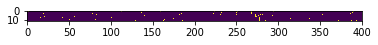

In [3]:

# the data, split between train and test sets
#(x_train, y_train), (x_test, y_test) = mnist.load_data()


###x_train, y_train = gen_n_tracks(batch_size=batch_size).__next__()

x_test, y_test = gen_n_tracks(batch_size=batch_size, n_tracks=mean_tracks, train = True).__next__()

###y_train = y_train
###y_test = y_test

# add noise
###noise_train = gen_noise(batch_size=batch_size).__next__()

noise_test = gen_noise(batch_size=batch_size, prob_noise=prob_noise, dims = 2).__next__()

###x_train = x_train+noise_train
x_test  = x_test+noise_test


###print("x_train ",x_train.shape)i
###print("y_train ",y_train.shape)




# print(x_train[0,0])
# print("Train targets ",y_train[0])
plt.imshow(x_test[0,0])
print("Test targets ",y_test[0])


#
# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     y_train = y_train.reshape(y_train.shape[0], 1, 2)
#     y_test = y_test.reshape(y_test.shape[0], 1, 2)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     y_train = y_train.reshape(y_train.shape[0], 2, 1)
#     y_test = y_test.reshape(y_test.shape[0], 2, 1)
#     input_shape = (img_rows, img_cols, 1)

###x_train = x_train.astype('int')

x_test = x_test.astype('int')
###x_train = np.clip(x_train, 0, 1)

x_test = np.clip(x_test, 0, 1)
#x_train /= 255
#x_test /= 255
#print('x_train shape:', x_train.shape)
#print(x_train.shape[0], 'train samples')
#print(x_test.shape[0], 'test samples')
#print('y_train shape:', y_train.shape)
#print(y_train.shape[0], 'train samples')
#print(y_test.shape[0], 'test samples')

In [4]:
#printing TPU information

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


W0801 11:55:15.827084 140040865830784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 11:55:15.880986 140040865830784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



input_shape  (1, 12, 400)


W0801 11:55:15.903209 140040865830784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0801 11:55:15.994094 140040865830784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0801 11:55:16.006209 140040865830784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[<tf.Tensor 'reshape_1/Reshape:0' shape=(?, 12, 400, 1) dtype=float32>, <tf.Tensor 'conv2d_1/Relu:0' shape=(?, 10, 398, 32) dtype=float32>, <tf.Tensor 'conv2d_2/Relu:0' shape=(?, 8, 336, 32) dtype=float32>, <tf.Tensor 'conv2d_3/Relu:0' shape=(?, 6, 328, 64) dtype=float32>, <tf.Tensor 'conv2d_4/Relu:0' shape=(?, 4, 326, 128) dtype=float32>, <tf.Tensor 'conv2d_5/Relu:0' shape=(?, 2, 324, 128) dtype=float32>, <tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, 2, 324, 128) dtype=float32>, <tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>, <tf.Tensor 'dense_1/Relu:0' shape=(?, 400) dtype=float32>, <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 400) dtype=float32>, <tf.Tensor 'dense_3/BiasAdd:0' shape=(?, 400) dtype=float32>, <tf.Tensor 'mdn_1/MDN/mdn_outputs/concat:0' shape=(?, 15) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 12, 400, 1)        0        

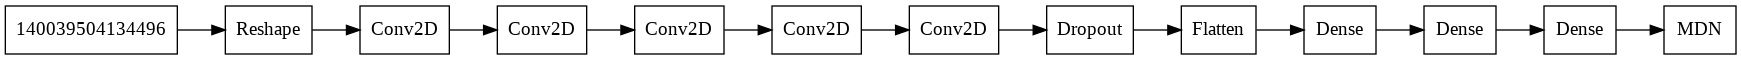

model.png  sample_data
Model shown
           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####      1   12  400
             Reshape     |   -------------------         0     0.0%
                       #####     12  400    1
              Conv2D    \|/  -------------------       320     0.0%
                relu   #####     10  398   32
              Conv2D    \|/  -------------------    193568     0.6%
                relu   #####      8  336   32
              Conv2D    \|/  -------------------     55360     0.2%
                relu   #####      6  328   64
              Conv2D    \|/  -------------------     73856     0.2%
                relu   #####      4  326  128
              Conv2D    \|/  -------------------    147584     0.4%
                relu   #####      2  324  128
             Dropout    | || -------------------         0     0.0%
                       #####      2  324  128
             Flatten   ||||| ------------------

In [5]:



start_training_time = time.time()

# if 'COLAB_TPU_ADDR' not in os.environ:

#   model = Sequential()
#   input_shape=(1,det_width, det_width, det_depth)

#   print("input_shape ",input_shape)

#   model.add(Reshape((det_width, det_width, det_depth,1),
#                                   input_shape=input_shape))
#   model.add(Conv3D(32, (3, 3, 3), activation='relu'))  #8
#   model.add(Conv3D(32, (3, 3, 3), activation='relu'))  #8
# #  model.add(Conv3D(32, (3, 3, 3), activation='relu'))  #added
#   model.add(MaxPooling3D(pool_size=(2, 2, 2)))
#   model.add(Conv3D(128, (3, 3, 3), activation='relu'))  #32
#   model.add(Conv3D(128, (3, 3, 3), activation='relu'))  #32
# #  model.add(Conv3D(128, (3, 3, 3), activation='relu'))  #added
#   model.add(Dropout(0.25))
#   model.add(Flatten())
#   model.add(Dense(400, activation='relu'))  # 400
# #  model.add(Dense(400))  # added
#   #model.add(Dropout(0.5))
#   #model.add(Dense(2, activation='tanh'))


#   model.add(RepeatVector(max_tracks))
#   model.add(LSTM(400, return_sequences=True))
#   model.add(TimeDistributed(Dense(4)))

#   # model.add(Flatten(input_shape=input_shape))
#   # #model.add(Reshape(input_shape - (1, ), input_shape=input_shape))
#   # model.add(Dense(32, activation='relu'))
#   # model.add(Dense(32, activation='relu'))
#   # model.add(Dense(32, activation='relu'))
#   # model.add(Dense(32, activation='relu'))
#   # #model.add(Dense(32, activation='relu'))
#   # #model.add(Dense(32, activation='relu'))
#   # model.add(Dropout(0.5))
#   # model.add(Dense(2, activation='tanh'))


#   #model.add(Reshape((1, 2),input_shape=(2,)))
#   model.add(Reshape((max_tracks, 4),input_shape=(4*max_tracks,)))

# else:
  ###stara sieć###
#   model = tf.keras.layers.Sequential()
#   input_shape=(1,det_width, det_width, det_depth)

#   print("input_shape ",input_shape)

#   model.add(Reshape((det_width, det_width, det_depth,1),
#                                   input_shape=input_shape))
#   model.add(Conv3D(32, (3, 3, 3), activation='relu'))  #8
#   model.add(tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu'))  #8
#   model.add(tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu'))  #added
#   model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)))
#   model.add(tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu'))  #32
#   model.add(tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu'))  #32
#   model.add(tf.keras.layers.Conv3D(128, (3, 3, 3), activation='relu'))  #added
#   model.add(tf.keras.layers.Dropout(0.25))
#   model.add(tf.keras.layers.Flatten())
#   model.add(tf.keras.layers.Dense(400, activation='relu'))  # 400
#   model.add(tf.keras.layers.Dense(400))  # added
#   #model.add(Dropout(0.5))
#   #model.add(Dense(2, activation='tanh'))


#   model.add(tf.keras.layers.RepeatVector(max_tracks))
#   model.add(tf.keras.layers.LSTM(400, return_sequences=True))
#   model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(4)))

#   # model.add(Flatten(input_shape=input_shape))
#   # #model.add(Reshape(input_shape - (1, ), input_shape=input_shape))
#   # model.add(Dense(32, activation='relu'))
#   # model.add(Dense(32, activation='relu'))
#   # model.add(Dense(32, activation='relu'))
#   # model.add(Dense(32, activation='relu'))
#   # #model.add(Dense(32, activation='relu'))
#   # #model.add(Dense(32, activation='relu'))
#   # model.add(Dropout(0.5))
#   # model.add(Dense(2, activation='tanh'))


#   #model.add(Reshape((1, 2),input_shape=(2,)))
#   model.add(tf.keras.layers.Reshape((max_tracks, 4),input_shape=(4*max_tracks,)))  

    ###zmiana na 2D###

model = Sequential()
input_shape=(1,det_depth, det_width)

print("input_shape ",input_shape)

model.add(Reshape((det_depth, det_width,1),
                                input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))  #8
model.add(Conv2D(32, (3, 63), activation='relu'))  #8
model.add(Conv2D(64, (3, 9), activation='relu'))  #added
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))  #32
model.add(Conv2D(128, (3, 3), activation='relu'))  #32
#model.add(Conv2D(128, (3, 3), activation='relu'))  #added
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(400, activation='relu'))  # 400
#model.add(Dense(400))
model.add(Dense(400))  # added
model.add(Dense(400))
#model.add(Dropout(0.5))
#model.add(Dense(2, activation='tanh'))


#model.add(RepeatVector(max_tracks))
#model.add(LSTM(400, return_sequences=True))
# model.add(TimeDistributed(Dense(2)))
#model.add(TimeDistributed(mdn.MDN(mdn_out,mdn_mix)))

model.add(mdn.MDN(mdn_out,mdn_mix))

# model.add(Flatten(input_shape=input_shape))
# #model.add(Reshape(input_shape - (1, ), input_shape=input_shape))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# #model.add(Dense(32, activation='relu'))
# #model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='tanh'))


#model.add(Reshape((1, 2),input_shape=(2,)))
#model.add(Reshape((max_tracks, 2),input_shape=(2*max_tracks,)))  

  
  ####koniec####
  

# print outputs for each layer
outputs =  [layer.output for layer in model.layers]
print (outputs)
print (model.summary())

print ("plotting model")
plot_model(model, to_file='model.png',rankdir='LR',show_shapes=False,show_layer_names=False )  ###, show_shapes=True

print ("Showing model")
from IPython.display import Image
display(Image(filename='model.png'))
!ls
print ("Model shown")

#sys.exit("Stopping here")



'''
    Converts a Keras model to dot format and save to a file.
    # Arguments
        model: A Keras model instance
        to_file: File name of the plot image.
        show_shapes: whether to display shape information.
        show_layer_names: whether to display layer names.
        rankdir: `rankdir` argument passed to PyDot,
            a string specifying the format of the plot:
            'TB' creates a vertical plot;
            'LR' creates a horizontal plot.
        expand_nested: whether to expand nested models into clusters.
        dpi: dot DPI.
'''

# Vizualizing model structure

sequential_model_to_ascii_printout(model)


#history=model.fit(x_train, y_train,
#          batch_size=batch_size_NN,
#          epochs=epochs,
#          verbose=1,
#          validation_data=(x_test, y_test))


#################Oryginalny data_generator################


# def data_generator(batch_size_gen=batch_size_NN,prob_noise=prob_noise,n_tracks=mean_tracks):
  
#   while True: 
#    # the data, split between train and test sets
#    #(x_train, y_train), (x_test, y_test) = mnist.load_data()

#     x_train, y_train = gen_n_tracks(batch_size=batch_size_gen,n_tracks=mean_tracks).__next__()
    

#      #y_train = y_train/100

#      # add noise
#     noise_train = gen_noise(batch_size=batch_size_gen,prob_noise=prob_noise).__next__()
#     x_train = x_train+noise_train

#      #print("x_train: ",x_train.shape)
#      #print("y_train: ",y_train.shape)
#     yield x_train, y_train
   
#   #print("generator ",data_generator())



In [0]:
def data_generator(batch_size_gen=batch_size_NN,prob_noise=prob_noise,n_tracks=mean_tracks):
  
  while True: 
   # the data, split between train and test sets
    x_train, y_train = gen_n_tracks(batch_size=batch_size_gen,n_tracks=n_tracks, train = True).__next__()
    #y_train = y_train[:, :,]

     # add noise
    noise_train = gen_noise(batch_size=batch_size_gen,prob_noise=prob_noise, dims = 2).__next__()
    x_train = x_train+noise_train
    
    x_train = np.clip(x_train, 0, 1)
#     print(x_train.shape)
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     x, y = x_train[0,0,:,:]
#     ax.scatter(x, y)
#     plt.show()
    
#     plt.imshow(np.asarray(x_train[0,0,:,:]))
   
     #print("x_train: ",x_train.shape)
     #print("y_train: ",y_train.shape)
    yield x_train, y_train
   

dg = data_generator(batch_size_gen=2, prob_noise = 0.05)
x, y = dg.__next__()

In [7]:


#using TPU model!!!
# This address identifies the TPU we'll use when configuring TensorFlow.


# if 'COLAB_TPU_ADDR'  in os.environ:  
#   TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
#   tf.logging.set_verbosity(tf.logging.INFO)

#   model = tf.contrib.tpu.keras_to_tpu_model(
#      model,
#      strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

#   model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
# else:


#  model.compile(
#      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
#                                      epsilon=1e-8), loss='mse')
#  rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.1)
#  model.compile(optimizer=rms, loss='mse')
#  model.compile(optimizer='Adam', loss='mean_squared_error')
  model.compile(optimizer='Adam', loss=mdn.get_mixture_loss_func(mdn_out,mdn_mix))

#model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
#model.compile(loss='mean_squared_error', optimizer='Adam')

#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.Adadelta(),
#              metrics=['accuracy'])


W0801 11:55:18.149363 140040865830784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0801 11:55:18.288892 140040865830784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.
W0801 11:55:18.438022 140040865830784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:2403: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in

In [8]:
'''
Warning 
if network learns to only fit one mixture to both tracks, it has gone into the minimum, training the network on larger noise and switching back
with to lower one with pretrained network may help
'''



#del model
#model = load_model('partly_trained.h5')
#prob_noise=0.005
# patient early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=12)  # 'val_loss'
mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1,
                     save_best_only=True)  # 'val_loss'

#train with fit_generator - generate events on flight
# pre-training with rms optimizer 
history=model.fit_generator(data_generator(prob_noise=prob_noise, n_tracks=mean_tracks),
                            steps_per_epoch=steps_per_epoch,
                            #validation_data=data_generator(), 
                            #validation_steps=steps_per_epoch,
                            epochs = 64 #pre_epochs
                            #,callbacks=[es
                                        #, mc]
                            #          ]
                           )

x_test, y_test = generate_testdata(prob_noise)
#plot_sample()
  
y_new = predict(model)
print("y_new shape: ",y_new.shape)
plot_predict(y_new)
plot_predict_event(y_new)

W0801 11:55:19.355682 140040865830784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/64
16/16 [==============================] - 31s 2s/step - loss: 41.7710
Epoch 2/64
16/16 [==============================] - 18s 1s/step - loss: 0.7083
Epoch 3/64
16/16 [==============================] - 18s 1s/step - loss: 0.2257
Epoch 4/64
16/16 [==============================] - 18s 1s/step - loss: 0.1123
Epoch 5/64
16/16 [==============================] - 18s 1s/step - loss: 0.0754
Epoch 6/64
16/16 [==============================] - 18s 1s/step - loss: -0.0279
Epoch 7/64
16/16 [==============================] - 18s 1s/step - loss: -0.0773
Epoch 8/64
16/16 [==============================] - 18s 1s/step - loss: -0.1556
Epoch 9/64
16/16 [==============================] - 18s 1s/step - loss: -0.1894
Epoch 10/64
16/16 [==============================] - 18s 1s/step - loss: -0.0219
Epoch 11/64
16/16 [==============================] - 18s 1s/step - loss: -0.1499
Epoch 12/64
16/16 [==============================] - 18s 1s/step - loss: -0.3476
Epoch 13/64
16/16 [======================

KeyboardInterrupt: ignored

In [0]:
# prob_noise=0.005
# x_test, y_test = generate_testdata(prob_noise)
# #plot_sample()

# y_new = predict(model)
# get_std(y_new)
# get_accuracy(y_new)
# print("y_new shape: ",y_new.shape)
# plot_predict(y_new)
# plot_predict_event(y_new)

In [0]:
# serialize weights to HDF5
model.save_weights(f"model_{img_rows}_{img_cols}_{prob_noise}.h5")
print("Saved model to disk")

In [0]:
model.load_weights(f"model_{img_rows}_{img_cols}_{prob_noise}.h5")
print("Model loaded from disk")

In [9]:
# summarize history for loss
plt.figure(figsize=(15,10))
plt.rc('font',size=20)
plt.plot(history.history['loss'])
###plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xlim(1, None)
plt.ylim(None,1)
#plt.ylim(ymax = 1.2*history.history['loss'][min(len(history.history['loss']),3)-1], ymin = 0)
print("history",history.history['loss'])
#plt.rc('font',size=50)
auxName = 'pretraining_'+str(efficiency)+'_'+str(prob_noise)+'.png'
plt.savefig(auxName)
  
plt.show()
#plt.savefig('training.png')
plt.clf()

NameError: ignored

<Figure size 1080x720 with 0 Axes>

In [0]:
# x_test, y_test = generate_testdata(prob_noise)
# #plot_sample()
  
# y_new = predict(model)
# print("y_new shape: ",y_new.shape)
# # plot_predict(y_new)
# plot_predict_event2(y_new)

In [0]:

# print("number of tracks ",mean_tracks)



# for prob_noise in [0, 0.050, 0.100, 0.150, 0.200]:
# #for prob_noise in [0.001, 0.004]:
  
#   train_model(model, prob_noise,epochs)
  

#   x_test, y_test = generate_testdata(prob_noise)
#   plot_sample()
  
#   y_new = predict(model)
#   print("y_new shape: ",y_new.shape)
#   plot_predict(y_new)
#   plot_predict_event(y_new)
  
#   write_predict(y_new)
  
#   !zip  /content/dnn_output_0.zip /content/*.png /content/*.txt

In [0]:
# file=open('acc.txt','w+')
# file2=open('std.txt','w+')

# print("number of tracks ",mean_tracks)

# accuracy_tab = []
# avg_std_tab = []
# tmp=[0, 0.050, 0.100, 0.150, 0.200,0.25,0.3,0.35,0.4]
# for prob_noise in [i*28/400for i in tmp]:
# #for prob_noise in [0.001, 0.004]:
#   tmp_acc=[]
#   tmp_std=[]
# #   train_model(model, prob_noise, epochs)
#   for i in range(5):
#     train_model(model, prob_noise, 64)


#     x_test, y_test = generate_testdata(prob_noise)
  
# #   plot_sample()
  
#     y_new = predict(model)
# #   print("y_new shape: ",y_new.shape)
# #   plot_predict(y_new)
# #   plot_predict_event(y_new)
  
#     tmp_acc.append(get_accuracy(y_new = y_new, sigmas = 3))
#     tmp_std.append(get_std(y_new = y_new))
  
# #   write_predict(y_new)
  
#   #!zip  /content/dnn_output_0.zip /content/*.png /content/*.txt
#   accuracy_tab.append(tmp_acc)
#   avg_std_tab.append(tmp_std)
  
#   print("accuracy_tab: ", accuracy_tab)
#   print("avg_std_tab: ", avg_std_tab)
  
#   file.write(str(accuracy_tab))
#   file2.write(str(avg_std_tab))
  
# file.close()
# file2.close()

In [0]:



# end_training_time = time.time()



# !zip  /content/dnn_output_final.zip /content/*.png /content/*.txt



# print ("    ")
# print ("###########################################################")
# print ("    ")
# print ("CPU usage: ")
# print ("Deep NN training:      ", end_training_time-start_training_time)
# #print ("Pattern recognition:   ", end_pattern_time-start_pattern_time)
# #print ("Track fitting:         ", end_fit_time-start_fit_time)
# print ("    ")
# print ("###########################################################")
# print ("    ")

